### Import Library

In [47]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import time
import datetime
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from fuzzywuzzy import process

### Read Data

In [48]:
# Membaca dataset
df = pd.read_excel('translate dataset/catania_english_dataset.xlsx')

# Menampilkan beberapa baris pertama dari dataframe
df.head()

,english_translation
0,The geese of Palermo. https://t.co/hN0WwJp67W
1,"Bad weather. Mediterranean cyclone on the way,..."
2,"Bad weather, downpour in Pantelleria. Damage a..."
3,"Bad Weather: Civil Protection, in Sicily it's ..."
4,"Bad weather in Sicily, the couple swept away b..."


### Labeling menggunakan TextBlob

In [49]:
# Fungsi untuk mendapatkan sentimen
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Terapkan analisis sentimen
df['textblob_polarity'] = df['english_translation'].apply(get_sentiment)

# Fungsi untuk memberi label sentimen
def label_textblob_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Terapkan pelabelan
df['textblob_sentiment_label'] = df['textblob_polarity'].apply(label_textblob_sentiment)

# Tampilkan dataframe yang telah diperbarui dengan label sentimen
df.head()

,english_translation,textblob_polarity,textblob_sentiment_label
0,The geese of Palermo. https://t.co/hN0WwJp67W,0.000,neutral
1,"Bad weather. Mediterranean cyclone on the way,...",-0.225,negative
2,"Bad weather, downpour in Pantelleria. Damage a...",-0.700,negative
3,"Bad Weather: Civil Protection, in Sicily it's ...",-0.350,negative
4,"Bad weather in Sicily, the couple swept away b...",-0.450,negative


### Labeling menggunakan VADER

In [50]:
# Inisialisasi analyzer sentimen VADER
analyzer = SentimentIntensityAnalyzer()

# Fungsi untuk mendapatkan sentimen menggunakan VADER
def vader_sentiment(text):
    return analyzer.polarity_scores(text)

# Fungsi untuk memberi label sentimen
def label_vader_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Terapkan analisis sentimen VADER
df['vader_scores'] = df['english_translation'].apply(vader_sentiment)

# Ekstrak skor individual
df['vader_compound'] = df['vader_scores'].apply(lambda x: x['compound'])

# Terapkan pelabelan
df['vader_sentiment_label'] = df['vader_compound'].apply(label_vader_sentiment)

# Tampilkan dataframe yang telah diperbarui
df.head()

,english_translation,textblob_polarity,textblob_sentiment_label,vader_scores,vader_compound,vader_sentiment_label
0,The geese of Palermo. https://t.co/hN0WwJp67W,0.000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,"Bad weather. Mediterranean cyclone on the way,...",-0.225,negative,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",-0.5423,negative
2,"Bad weather, downpour in Pantelleria. Damage a...",-0.700,negative,"{'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'comp...",-0.8481,negative
3,"Bad Weather: Civil Protection, in Sicily it's ...",-0.350,negative,"{'neg': 0.223, 'neu': 0.637, 'pos': 0.14, 'com...",-0.3182,negative
4,"Bad weather in Sicily, the couple swept away b...",-0.450,negative,"{'neg': 0.251, 'neu': 0.749, 'pos': 0.0, 'comp...",-0.6908,negative


### Labeling menggunakan AFINN

In [51]:
# Inisialisasi AFINN
afinn = Afinn()

# Terapkan fungsi AFINN untuk menghitung skor sentimen
df['afinn_sentiment_score'] = df['english_translation'].apply(lambda x: afinn.score(str(x)))

# Beri label sentimen berdasarkan skor
def assign_sentiment_label(score):
    if score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else:
        return "neutral"

df['afinn_sentiment_label'] = df['afinn_sentiment_score'].apply(assign_sentiment_label)

# Lihat hasil
df.head()

,english_translation,textblob_polarity,textblob_sentiment_label,vader_scores,vader_compound,vader_sentiment_label,afinn_sentiment_score,afinn_sentiment_label
0,The geese of Palermo. https://t.co/hN0WwJp67W,0.000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.0,neutral
1,"Bad weather. Mediterranean cyclone on the way,...",-0.225,negative,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",-0.5423,negative,-3.0,negative
2,"Bad weather, downpour in Pantelleria. Damage a...",-0.700,negative,"{'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'comp...",-0.8481,negative,-8.0,negative
3,"Bad Weather: Civil Protection, in Sicily it's ...",-0.350,negative,"{'neg': 0.223, 'neu': 0.637, 'pos': 0.14, 'com...",-0.3182,negative,-4.0,negative
4,"Bad weather in Sicily, the couple swept away b...",-0.450,negative,"{'neg': 0.251, 'neu': 0.749, 'pos': 0.0, 'comp...",-0.6908,negative,-5.0,negative


In [52]:
# Menghapus baris kosong
df = df.dropna()

# Menghapus baris duplikat berdasarkan kolom yang tidak mengandung dictionary
df = df.drop_duplicates(subset=['english_translation', 'textblob_polarity', 'textblob_sentiment_label', 'vader_compound', 'vader_sentiment_label', 'afinn_sentiment_score', 'afinn_sentiment_label'])

# Verifikasi hasil
print(f"Jumlah baris setelah menghapus baris kosong dan duplikat: {len(df)}")
df.head()

Jumlah baris setelah menghapus baris kosong dan duplikat: 202


,english_translation,textblob_polarity,textblob_sentiment_label,vader_scores,vader_compound,vader_sentiment_label,afinn_sentiment_score,afinn_sentiment_label
0,The geese of Palermo. https://t.co/hN0WwJp67W,0.000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.0,neutral
1,"Bad weather. Mediterranean cyclone on the way,...",-0.225,negative,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",-0.5423,negative,-3.0,negative
2,"Bad weather, downpour in Pantelleria. Damage a...",-0.700,negative,"{'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'comp...",-0.8481,negative,-8.0,negative
3,"Bad Weather: Civil Protection, in Sicily it's ...",-0.350,negative,"{'neg': 0.223, 'neu': 0.637, 'pos': 0.14, 'com...",-0.3182,negative,-4.0,negative
4,"Bad weather in Sicily, the couple swept away b...",-0.450,negative,"{'neg': 0.251, 'neu': 0.749, 'pos': 0.0, 'comp...",-0.6908,negative,-5.0,negative


In [53]:
# Mengecek apakah ada baris yang semua kolomnya kosong
kosong = df.isnull().all(axis=1)

# Menampilkan jumlah baris yang kosong seluruhnya
print(f"Jumlah baris yang kosong seluruhnya: {kosong.sum()}")

# Menampilkan baris-baris yang kosong seluruhnya
print(df[kosong])

Jumlah baris yang kosong seluruhnya: 0
Empty DataFrame
Columns: [english_translation, textblob_polarity, textblob_sentiment_label, vader_scores, vader_compound, vader_sentiment_label, afinn_sentiment_score, afinn_sentiment_label]
Index: []


### Menentukan Ground Truth

In [54]:
# Fungsi untuk menentukan ground truth berdasarkan majority voting
def determine_ground_truth(row):
    labels = [row['textblob_sentiment_label'], row['vader_sentiment_label'], row['afinn_sentiment_label']]
    
    # Hitung jumlah masing-masing label
    label_counts = {label: labels.count(label) for label in set(labels)}
    
    # Jika ketiga label sama, ambil label tersebut
    if len(label_counts) == 1:
        return labels[0]  # Semua label sama, ambil salah satu (semua sama saja)
    
    # Jika ada mayoritas (2 label sama), ambil yang terbanyak
    if max(label_counts.values()) == 2:
        return max(label_counts, key=label_counts.get)
    
    # Jika semua label berbeda, kosongkan (akan diisi manual)
    return None

# Terapkan fungsi untuk menentukan ground truth
df['ground_truth_sentiment_label'] = df.apply(determine_ground_truth, axis=1)

# Tampilkan dataframe yang telah diperbarui dengan ground truth
df.head()

,english_translation,textblob_polarity,textblob_sentiment_label,vader_scores,vader_compound,vader_sentiment_label,afinn_sentiment_score,afinn_sentiment_label,ground_truth_sentiment_label
0,The geese of Palermo. https://t.co/hN0WwJp67W,0.000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.0,neutral,neutral
1,"Bad weather. Mediterranean cyclone on the way,...",-0.225,negative,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",-0.5423,negative,-3.0,negative,negative
2,"Bad weather, downpour in Pantelleria. Damage a...",-0.700,negative,"{'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'comp...",-0.8481,negative,-8.0,negative,negative
3,"Bad Weather: Civil Protection, in Sicily it's ...",-0.350,negative,"{'neg': 0.223, 'neu': 0.637, 'pos': 0.14, 'com...",-0.3182,negative,-4.0,negative,negative
4,"Bad weather in Sicily, the couple swept away b...",-0.450,negative,"{'neg': 0.251, 'neu': 0.749, 'pos': 0.0, 'comp...",-0.6908,negative,-5.0,negative,negative


In [55]:
# Simpan DataFrame dengan ground truth sentiment label ke file Excel
df.to_excel('Ground Truth/hasil_ground_truth_sentiment_labels_catania.xlsx', index=False)

# Konfirmasi bahwa file telah disimpan
print("DataFrame dengan label sentimen ground truth telah disimpan ke 'hasil_ground_truth_sentiment_labels_catania.xlsx'")

DataFrame dengan label sentimen ground truth telah disimpan ke 'hasil_ground_truth_sentiment_labels_catania.xlsx'


data catania ada 6 text yang diberi label secara manual.

In [56]:
# Baca hasil ground truth yang telah diperbarui dari file Excel
df_updated = pd.read_excel('Ground Truth/hasil_ground_truth_sentiment_labels_catania_updated.xlsx')

# Tampilkan beberapa baris pertama dari dataframe yang telah diperbarui
df_updated.head()

,english_translation,textblob_polarity,textblob_sentiment_label,vader_scores,vader_compound,vader_sentiment_label,afinn_sentiment_score,afinn_sentiment_label,ground_truth_sentiment_label
0,The geese of Palermo. https://t.co/hN0WwJp67W,0.000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0,neutral,neutral
1,"Bad weather. Mediterranean cyclone on the way,...",-0.225,negative,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",-0.5423,negative,-3,negative,negative
2,"Bad weather, downpour in Pantelleria. Damage a...",-0.700,negative,"{'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'comp...",-0.8481,negative,-8,negative,negative
3,"Bad Weather: Civil Protection, in Sicily it's ...",-0.350,negative,"{'neg': 0.223, 'neu': 0.637, 'pos': 0.14, 'com...",-0.3182,negative,-4,negative,negative
4,"Bad weather in Sicily, the couple swept away b...",-0.450,negative,"{'neg': 0.251, 'neu': 0.749, 'pos': 0.0, 'comp...",-0.6908,negative,-5,negative,negative


In [57]:
df['ground_truth_sentiment_label'].value_counts()

ground_truth_sentiment_label
neutral     93
negative    86
positive    17
Name: count, dtype: int64

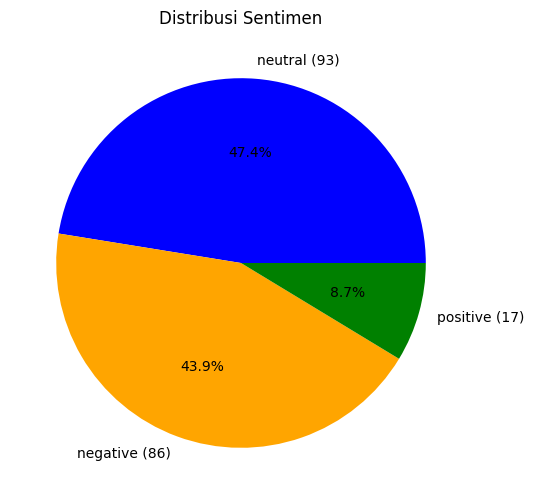

In [58]:
# Definisikan warna untuk setiap label sentimen
colors = {
    'positive': 'green',
    'negative': 'orange',
    'neutral': 'blue'
}

# Hitung jumlah nilai untuk masing-masing kelas
sentiment_counts = df['ground_truth_sentiment_label'].value_counts()

# Set label dengan jumlah
labels = [f"{label} ({count})" for label, count in sentiment_counts.items()]

# Buat pie chart
plt.figure(figsize=(10, 6))
sentiment_counts.plot.pie(
    autopct='%1.1f%%',
    colors=[colors[label.split(' ')[0]] for label in labels],
    labels=labels
)

plt.title('Distribusi Sentimen')
plt.ylabel('')
plt.show()


### Pra-pemrosesan Data

In [59]:
# Daftar nama kota
city_list = [
    "catania", "palermo", "sicily", "pantelleria", "scordia", "milazzo", "messina", 
    "valletta", "malta", "syracuse", "piazza alcala", "mascali", "gravina", 
    "palogonia", "italy", "calabria", "sardinia", "augusta", "siracusa", "trapani"
]

# Fungsi untuk membersihkan teks
def clean_text(text):
    # Hapus mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Hapus hashtags
    text = re.sub(r'#\w+', '', text)
    # Hapus retweets
    text = re.sub(r'RT[\s]+', '', text)
    # Hapus URLs
    text = re.sub(r'https?://\S+', '', text)
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    # Hapus tanggal (format seperti 16aug, 16Aug, dll)
    text = re.sub(r'\d+(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*', '', text, flags=re.IGNORECASE)

    # Identifikasi nama kota yang mungkin salah ejaan
    words = text.split()
    for word in words:
        # Cari kecocokan terbaik dengan daftar kota
        match, score = process.extractOne(word, city_list)
        if score > 90:  # Skor kemiripan >80 dianggap cocok
            text = text.replace(word, '')  # Hapus nama kota

    # Hapus karakter non-alphanumeric kecuali spasi
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Terapkan fungsi pembersihan pada kolom 'english_translation'
df['cleaned_text'] = df['english_translation'].apply(clean_text)

# Tampilkan dataframe yang telah dibersihkan
df.head()

,english_translation,textblob_polarity,textblob_sentiment_label,vader_scores,vader_compound,vader_sentiment_label,afinn_sentiment_score,afinn_sentiment_label,ground_truth_sentiment_label,cleaned_text
0,The geese of Palermo. https://t.co/hN0WwJp67W,0.000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.0,neutral,neutral,The geese of
1,"Bad weather. Mediterranean cyclone on the way,...",-0.225,negative,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",-0.5423,negative,-3.0,negative,negative,Bad weather Mediterranean cyclone on the way f...
2,"Bad weather, downpour in Pantelleria. Damage a...",-0.700,negative,"{'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'comp...",-0.8481,negative,-8.0,negative,negative,Bad weather downpour in Damage and disruption ...
3,"Bad Weather: Civil Protection, in Sicily it's ...",-0.350,negative,"{'neg': 0.223, 'neu': 0.637, 'pos': 0.14, 'com...",-0.3182,negative,-4.0,negative,negative,Bad Weather Civil Protection in its red alert
4,"Bad weather in Sicily, the couple swept away b...",-0.450,negative,"{'neg': 0.251, 'neu': 0.749, 'pos': 0.0, 'comp...",-0.6908,negative,-5.0,negative,negative,Bad weather in the couple swept away by the mu...


In [60]:
# Menghapus baris duplikat berdasarkan kolom 'cleaned_text'
df = df.drop_duplicates(subset=['cleaned_text'])

# Menghapus baris dengan kolom yang kosong
df = df.dropna()

# Verifikasi hasil
print(f"Jumlah baris setelah menghapus duplikat dan kolom kosong: {len(df)}")
df.head()

Jumlah baris setelah menghapus duplikat dan kolom kosong: 166


,english_translation,textblob_polarity,textblob_sentiment_label,vader_scores,vader_compound,vader_sentiment_label,afinn_sentiment_score,afinn_sentiment_label,ground_truth_sentiment_label,cleaned_text
0,The geese of Palermo. https://t.co/hN0WwJp67W,0.000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.0,neutral,neutral,The geese of
1,"Bad weather. Mediterranean cyclone on the way,...",-0.225,negative,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",-0.5423,negative,-3.0,negative,negative,Bad weather Mediterranean cyclone on the way f...
2,"Bad weather, downpour in Pantelleria. Damage a...",-0.700,negative,"{'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'comp...",-0.8481,negative,-8.0,negative,negative,Bad weather downpour in Damage and disruption ...
3,"Bad Weather: Civil Protection, in Sicily it's ...",-0.350,negative,"{'neg': 0.223, 'neu': 0.637, 'pos': 0.14, 'com...",-0.3182,negative,-4.0,negative,negative,Bad Weather Civil Protection in its red alert
4,"Bad weather in Sicily, the couple swept away b...",-0.450,negative,"{'neg': 0.251, 'neu': 0.749, 'pos': 0.0, 'comp...",-0.6908,negative,-5.0,negative,negative,Bad weather in the couple swept away by the mu...


In [61]:
# Terapkan case folding pada kolom 'cleaned_text'
def apply_case_folding(df, column_name):
    df[column_name] = df[column_name].str.lower()
    return df

# Terapkan case folding pada kolom 'cleaned_text' dan simpan di kolom baru
df['case_folded_text'] = df['cleaned_text'].str.lower()

# Tampilkan dataframe yang telah diperbarui
df.head()

,english_translation,textblob_polarity,textblob_sentiment_label,vader_scores,vader_compound,vader_sentiment_label,afinn_sentiment_score,afinn_sentiment_label,ground_truth_sentiment_label,cleaned_text,case_folded_text
0,The geese of Palermo. https://t.co/hN0WwJp67W,0.000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.0,neutral,neutral,The geese of,the geese of
1,"Bad weather. Mediterranean cyclone on the way,...",-0.225,negative,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",-0.5423,negative,-3.0,negative,negative,Bad weather Mediterranean cyclone on the way f...,bad weather mediterranean cyclone on the way f...
2,"Bad weather, downpour in Pantelleria. Damage a...",-0.700,negative,"{'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'comp...",-0.8481,negative,-8.0,negative,negative,Bad weather downpour in Damage and disruption ...,bad weather downpour in damage and disruption ...
3,"Bad Weather: Civil Protection, in Sicily it's ...",-0.350,negative,"{'neg': 0.223, 'neu': 0.637, 'pos': 0.14, 'com...",-0.3182,negative,-4.0,negative,negative,Bad Weather Civil Protection in its red alert,bad weather civil protection in its red alert
4,"Bad weather in Sicily, the couple swept away b...",-0.450,negative,"{'neg': 0.251, 'neu': 0.749, 'pos': 0.0, 'comp...",-0.6908,negative,-5.0,negative,negative,Bad weather in the couple swept away by the mu...,bad weather in the couple swept away by the mu...


In [62]:
nltk.download('punkt')

# Fungsi untuk melakukan tokenisasi teks
def tokenize_text(text):
    return word_tokenize(text)

# Terapkan tokenisasi pada kolom 'case_folded_text' dan simpan di kolom baru
df['tokenized_text'] = df['case_folded_text'].apply(tokenize_text)

# Tampilkan dataframe yang telah diperbarui
df.head()

[nltk_data] Downloading package punkt to C:\Users\YOGA
[nltk_data]     PRATAMA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,english_translation,textblob_polarity,textblob_sentiment_label,vader_scores,vader_compound,vader_sentiment_label,afinn_sentiment_score,afinn_sentiment_label,ground_truth_sentiment_label,cleaned_text,case_folded_text,tokenized_text
0,The geese of Palermo. https://t.co/hN0WwJp67W,0.000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.0,neutral,neutral,The geese of,the geese of,"[the, geese, of]"
1,"Bad weather. Mediterranean cyclone on the way,...",-0.225,negative,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",-0.5423,negative,-3.0,negative,negative,Bad weather Mediterranean cyclone on the way f...,bad weather mediterranean cyclone on the way f...,"[bad, weather, mediterranean, cyclone, on, the..."
2,"Bad weather, downpour in Pantelleria. Damage a...",-0.700,negative,"{'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'comp...",-0.8481,negative,-8.0,negative,negative,Bad weather downpour in Damage and disruption ...,bad weather downpour in damage and disruption ...,"[bad, weather, downpour, in, damage, and, disr..."
3,"Bad Weather: Civil Protection, in Sicily it's ...",-0.350,negative,"{'neg': 0.223, 'neu': 0.637, 'pos': 0.14, 'com...",-0.3182,negative,-4.0,negative,negative,Bad Weather Civil Protection in its red alert,bad weather civil protection in its red alert,"[bad, weather, civil, protection, in, its, red..."
4,"Bad weather in Sicily, the couple swept away b...",-0.450,negative,"{'neg': 0.251, 'neu': 0.749, 'pos': 0.0, 'comp...",-0.6908,negative,-5.0,negative,negative,Bad weather in the couple swept away by the mu...,bad weather in the couple swept away by the mu...,"[bad, weather, in, the, couple, swept, away, b..."


In [63]:
# Unduh stopwords
nltk.download('stopwords')

# Dapatkan daftar stopwords dalam bahasa Inggris
stop_words = set(stopwords.words('english'))

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Terapkan penghapusan stopwords pada kolom 'case_folded_text' dan simpan di kolom baru
df['text_without_stopwords'] = df['case_folded_text'].apply(remove_stopwords)

# Tampilkan dataframe yang telah diperbarui
df.head()

[nltk_data] Downloading package stopwords to C:\Users\YOGA
[nltk_data]     PRATAMA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,english_translation,textblob_polarity,textblob_sentiment_label,vader_scores,vader_compound,vader_sentiment_label,afinn_sentiment_score,afinn_sentiment_label,ground_truth_sentiment_label,cleaned_text,case_folded_text,tokenized_text,text_without_stopwords
0,The geese of Palermo. https://t.co/hN0WwJp67W,0.000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.0,neutral,neutral,The geese of,the geese of,"[the, geese, of]",geese
1,"Bad weather. Mediterranean cyclone on the way,...",-0.225,negative,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",-0.5423,negative,-3.0,negative,negative,Bad weather Mediterranean cyclone on the way f...,bad weather mediterranean cyclone on the way f...,"[bad, weather, mediterranean, cyclone, on, the...",bad weather mediterranean cyclone way first ef...
2,"Bad weather, downpour in Pantelleria. Damage a...",-0.700,negative,"{'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'comp...",-0.8481,negative,-8.0,negative,negative,Bad weather downpour in Damage and disruption ...,bad weather downpour in damage and disruption ...,"[bad, weather, downpour, in, damage, and, disr...",bad weather downpour damage disruption through...
3,"Bad Weather: Civil Protection, in Sicily it's ...",-0.350,negative,"{'neg': 0.223, 'neu': 0.637, 'pos': 0.14, 'com...",-0.3182,negative,-4.0,negative,negative,Bad Weather Civil Protection in its red alert,bad weather civil protection in its red alert,"[bad, weather, civil, protection, in, its, red...",bad weather civil protection red alert
4,"Bad weather in Sicily, the couple swept away b...",-0.450,negative,"{'neg': 0.251, 'neu': 0.749, 'pos': 0.0, 'comp...",-0.6908,negative,-5.0,negative,negative,Bad weather in the couple swept away by the mu...,bad weather in the couple swept away by the mu...,"[bad, weather, in, the, couple, swept, away, b...",bad weather couple swept away mud still missing


In [64]:
# Inisialisasi stemmer
stemmer = PorterStemmer()

# Fungsi untuk melakukan stemming pada teks
def stem_text(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Terapkan stemming pada kolom 'text_without_stopwords' dan simpan hasilnya di kolom baru
df['stemmed_text'] = df['text_without_stopwords'].apply(stem_text)

# Tampilkan dataframe yang telah diperbarui
df.head()

,english_translation,textblob_polarity,textblob_sentiment_label,vader_scores,vader_compound,vader_sentiment_label,afinn_sentiment_score,afinn_sentiment_label,ground_truth_sentiment_label,cleaned_text,case_folded_text,tokenized_text,text_without_stopwords,stemmed_text
0,The geese of Palermo. https://t.co/hN0WwJp67W,0.000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.0,neutral,neutral,The geese of,the geese of,"[the, geese, of]",geese,gees
1,"Bad weather. Mediterranean cyclone on the way,...",-0.225,negative,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",-0.5423,negative,-3.0,negative,negative,Bad weather Mediterranean cyclone on the way f...,bad weather mediterranean cyclone on the way f...,"[bad, weather, mediterranean, cyclone, on, the...",bad weather mediterranean cyclone way first ef...,bad weather mediterranean cyclon way first eff...
2,"Bad weather, downpour in Pantelleria. Damage a...",-0.700,negative,"{'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'comp...",-0.8481,negative,-8.0,negative,negative,Bad weather downpour in Damage and disruption ...,bad weather downpour in damage and disruption ...,"[bad, weather, downpour, in, damage, and, disr...",bad weather downpour damage disruption through...,bad weather downpour damag disrupt throughout ...
3,"Bad Weather: Civil Protection, in Sicily it's ...",-0.350,negative,"{'neg': 0.223, 'neu': 0.637, 'pos': 0.14, 'com...",-0.3182,negative,-4.0,negative,negative,Bad Weather Civil Protection in its red alert,bad weather civil protection in its red alert,"[bad, weather, civil, protection, in, its, red...",bad weather civil protection red alert,bad weather civil protect red alert
4,"Bad weather in Sicily, the couple swept away b...",-0.450,negative,"{'neg': 0.251, 'neu': 0.749, 'pos': 0.0, 'comp...",-0.6908,negative,-5.0,negative,negative,Bad weather in the couple swept away by the mu...,bad weather in the couple swept away by the mu...,"[bad, weather, in, the, couple, swept, away, b...",bad weather couple swept away mud still missing,bad weather coupl swept away mud still miss


In [65]:
# Tampilkan 5 baris pertama dari kolom yang ditentukan
df[['cleaned_text', 'case_folded_text', 'tokenized_text', 'text_without_stopwords', 'stemmed_text']].head()


,cleaned_text,case_folded_text,tokenized_text,text_without_stopwords,stemmed_text
0,The geese of,the geese of,"[the, geese, of]",geese,gees
1,Bad weather Mediterranean cyclone on the way f...,bad weather mediterranean cyclone on the way f...,"[bad, weather, mediterranean, cyclone, on, the...",bad weather mediterranean cyclone way first ef...,bad weather mediterranean cyclon way first eff...
2,Bad weather downpour in Damage and disruption ...,bad weather downpour in damage and disruption ...,"[bad, weather, downpour, in, damage, and, disr...",bad weather downpour damage disruption through...,bad weather downpour damag disrupt throughout ...
3,Bad Weather Civil Protection in its red alert,bad weather civil protection in its red alert,"[bad, weather, civil, protection, in, its, red...",bad weather civil protection red alert,bad weather civil protect red alert
4,Bad weather in the couple swept away by the mu...,bad weather in the couple swept away by the mu...,"[bad, weather, in, the, couple, swept, away, b...",bad weather couple swept away mud still missing,bad weather coupl swept away mud still miss


In [66]:
# Tambahkan fitur tambahan
df['text_length'] = df['english_translation'].apply(len)
df['word_count'] = df['english_translation'].apply(lambda x: len(x.split()))

### Pembobotan

In [67]:
# Data sampel
documents = df['stemmed_text'].tolist()

# Inisialisasi TF-IDF Vectorizer dengan parameter yang ditentukan
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 1), min_df=3)

# Fit dan transformasi data teks
X_tfidf = tfidf_vectorizer.fit_transform(documents)

# Dapatkan nama fitur
feature_names = tfidf_vectorizer.get_feature_names_out()

# Hitung TF (Term Frequency)
tf = np.array(X_tfidf.toarray())

# Konversi ke DataFrame untuk keterbacaan yang lebih baik
tf_df = pd.DataFrame(tf, columns=feature_names)

# Tampilkan hasil
print("TF (Term Frequency):")
print(tf_df.head())

TF (Term Frequency):
      alert  anoth  area       bad  break  car  caus  citi     civil  close  \
0  0.000000    0.0   0.0  0.000000    0.0  0.0   0.0   0.0  0.000000    0.0   
1  0.000000    0.0   0.0  0.343796    0.0  0.0   0.0   0.0  0.000000    0.0   
2  0.000000    0.0   0.0  0.355661    0.0  0.0   0.0   0.0  0.000000    0.0   
3  0.414481    0.0   0.0  0.259468    0.0  0.0   0.0   0.0  0.500208    0.0   
4  0.000000    0.0   0.0  0.296599    0.0  0.0   0.0   0.0  0.000000    0.0   

   ...  street  today  torrenti  tragedi  turn  two  video  water   weather  \
0  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.000000   
1  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.340250   
2  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.351993   
3  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.256792   
4  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.293539   

   woman  
0    0.0  
1    0.

In [68]:
# Hitung TF Normalisasi
tf_sum = tf.sum(axis=1, keepdims=True)
tf_sum[tf_sum == 0] = 1  # Hindari pembagian dengan nol
tf_normalized = tf / tf_sum

# Konversi ke DataFrame untuk keterbacaan yang lebih baik
tf_normalized_df = pd.DataFrame(tf_normalized, columns=feature_names)

# Tampilkan hasil
print("\nTF Normalisasi:")
print(tf_normalized_df.head())


TF Normalisasi:
      alert  anoth  area       bad  break  car  caus  citi     civil  close  \
0  0.000000    0.0   0.0  0.000000    0.0  0.0   0.0   0.0  0.000000    0.0   
1  0.000000    0.0   0.0  0.178916    0.0  0.0   0.0   0.0  0.000000    0.0   
2  0.000000    0.0   0.0  0.184365    0.0  0.0   0.0   0.0  0.000000    0.0   
3  0.174724    0.0   0.0  0.109379    0.0  0.0   0.0   0.0  0.210862    0.0   
4  0.000000    0.0   0.0  0.137550    0.0  0.0   0.0   0.0  0.000000    0.0   

   ...  street  today  torrenti  tragedi  turn  two  video  water   weather  \
0  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.000000   
1  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.177071   
2  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.182464   
3  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.108250   
4  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.136131   

   woman  
0    0.0  
1    0.0  


In [69]:
# Hitung IDF (Inverse Document Frequency)
idf = np.log((1 + len(documents)) / (1 + (tf > 0).sum(axis=0))) + 1

# Konversi ke DataFrame untuk keterbacaan yang lebih baik
idf_df = pd.DataFrame(idf, index=feature_names, columns=["IDF"])

# Tampilkan hasil
print("\nIDF (Inverse Document Frequency):")
print(idf_df.head())


IDF (Inverse Document Frequency):
            IDF
alert  3.920769
anoth  4.508556
area   4.326234
bad    2.454432
break  4.038552


In [70]:
# Hitung TF-IDF Normalisasi
tfidf_normalized = tf_normalized * idf

# Konversi ke DataFrame untuk keterbacaan yang lebih baik
tfidf_normalized_df = pd.DataFrame(tfidf_normalized, columns=feature_names)

# Tampilkan hasil
print("\nTF-IDF Normalisasi:")
print(tfidf_normalized_df.head())


TF-IDF Normalisasi:
      alert  anoth  area       bad  break  car  caus  citi     civil  close  \
0  0.000000    0.0   0.0  0.000000    0.0  0.0   0.0   0.0  0.000000    0.0   
1  0.000000    0.0   0.0  0.439138    0.0  0.0   0.0   0.0  0.000000    0.0   
2  0.000000    0.0   0.0  0.452512    0.0  0.0   0.0   0.0  0.000000    0.0   
3  0.685052    0.0   0.0  0.268462    0.0  0.0   0.0   0.0  0.997735    0.0   
4  0.000000    0.0   0.0  0.337608    0.0  0.0   0.0   0.0  0.000000    0.0   

   ...  street  today  torrenti  tragedi  turn  two  video  water   weather  \
0  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.000000   
1  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.430125   
2  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.443225   
3  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.262952   
4  ...     0.0    0.0       0.0      0.0   0.0  0.0    0.0    0.0  0.330679   

   woman  
0    0.0  
1    0.

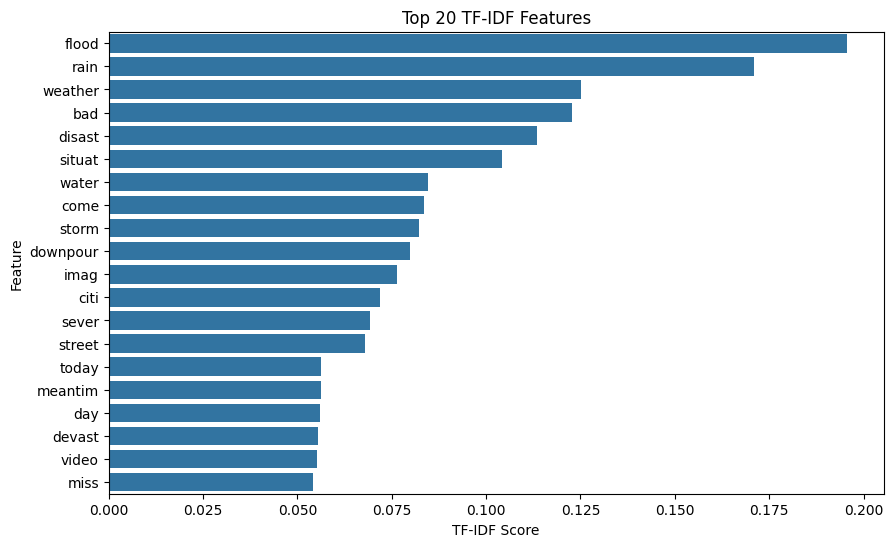

In [71]:
# Tampilkan 20 fitur TF-IDF teratas
top_n = 20
# Kecualikan kolom non-numerik
numeric_tfidf_df = tfidf_normalized_df.select_dtypes(include=[np.number])
tfidf_means = numeric_tfidf_df.mean().sort_values(ascending=False)[:top_n]

plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_means.values, y=tfidf_means.index)
plt.title('Top 20 TF-IDF Features')
plt.xlabel('TF-IDF Score')
plt.ylabel('Feature')
plt.show()

### Klasifikasi SVM, Pengujian dan Evaluasi


===== SVM with linear kernel =====
===== K-Fold Cross Validation Results =====

Fold 1:
Training time: 0:00:00.004572
Accuracy: 0.5882

Fold 2:
Training time: 0:00:00.002996
Accuracy: 0.8235

Fold 3:
Training time: 0:00:00.003031
Accuracy: 0.7059

Fold 4:
Training time: 0:00:00.003294
Accuracy: 0.6471

Fold 5:
Training time: 0:00:00.003193
Accuracy: 0.6471

Fold 6:
Training time: 0:00:00.005983
Accuracy: 0.7647

Fold 7:
Training time: 0:00:00.003996
Accuracy: 0.7500

Fold 8:
Training time: 0:00:00.005005
Accuracy: 0.7500

Fold 9:
Training time: 0:00:00.002486
Accuracy: 0.7500

Fold 10:
Training time: 0:00:00.002105
Accuracy: 0.6250

===== Overall Model Performance =====
Mean Accuracy: 0.7051
Standard Deviation: 0.0710
Average Training Time: 0:00:00.003666

===== Combined Performance Metrics =====
Overall Accuracy: 0.7048
Overall Precision: 0.7879
Overall Recall: 0.7048
Overall F1 Score: 0.7113
Overall Error Rate: 0.2952

Combined Confusion Matrix:
[[51 27  8]
 [ 0 56  7]
 [ 1  6 10]]


<Figure size 800x600 with 0 Axes>

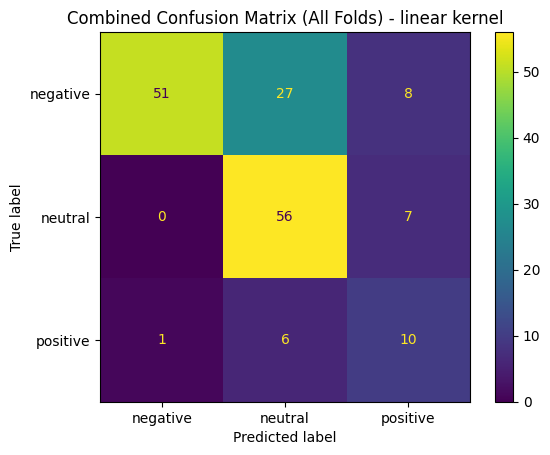


===== SVM with poly kernel =====
===== K-Fold Cross Validation Results =====

Fold 1:
Training time: 0:00:00.001983
Accuracy: 0.5882

Fold 2:
Training time: 0:00:00.003000
Accuracy: 0.8235

Fold 3:
Training time: 0:00:00.008001
Accuracy: 0.5294

Fold 4:
Training time: 0:00:00.005172
Accuracy: 0.6471

Fold 5:
Training time: 0:00:00.001992
Accuracy: 0.6471

Fold 6:
Training time: 0:00:00.004537
Accuracy: 0.5882

Fold 7:
Training time: 0:00:00.001997
Accuracy: 0.8125

Fold 8:
Training time: 0:00:00.002001
Accuracy: 0.6250

Fold 9:
Training time: 0:00:00.004454
Accuracy: 0.8125

Fold 10:
Training time: 0:00:00.004038
Accuracy: 0.7500

===== Overall Model Performance =====
Mean Accuracy: 0.6824
Standard Deviation: 0.1026
Average Training Time: 0:00:00.003718

===== Combined Performance Metrics =====
Overall Accuracy: 0.6807
Overall Precision: 0.6835
Overall Recall: 0.6807
Overall F1 Score: 0.6652
Overall Error Rate: 0.3193

Combined Confusion Matrix:
[[60 25  1]
 [10 51  2]
 [ 4 11  2]]

C

<Figure size 800x600 with 0 Axes>

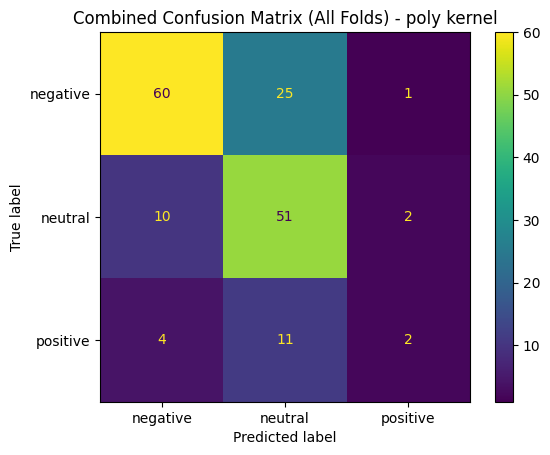


===== SVM with rbf kernel =====
===== K-Fold Cross Validation Results =====

Fold 1:
Training time: 0:00:00.004375
Accuracy: 0.6471

Fold 2:
Training time: 0:00:00.002993
Accuracy: 0.5882

Fold 3:
Training time: 0:00:00.001998
Accuracy: 0.6471

Fold 4:
Training time: 0:00:00.007004
Accuracy: 0.8235

Fold 5:
Training time: 0:00:00.003191
Accuracy: 0.7059

Fold 6:
Training time: 0:00:00.008373
Accuracy: 0.5882

Fold 7:
Training time: 0:00:00.004077
Accuracy: 0.8125

Fold 8:
Training time: 0:00:00.004001
Accuracy: 0.6250

Fold 9:
Training time: 0:00:00.004292
Accuracy: 0.7500

Fold 10:
Training time: 0:00:00.004375
Accuracy: 0.6250

===== Overall Model Performance =====
Mean Accuracy: 0.6813
Standard Deviation: 0.0829
Average Training Time: 0:00:00.004468

===== Combined Performance Metrics =====
Overall Accuracy: 0.6807
Overall Precision: 0.6756
Overall Recall: 0.6807
Overall F1 Score: 0.6705
Overall Error Rate: 0.3193

Combined Confusion Matrix:
[[62 22  2]
 [12 48  3]
 [ 5  9  3]]

Co

<Figure size 800x600 with 0 Axes>

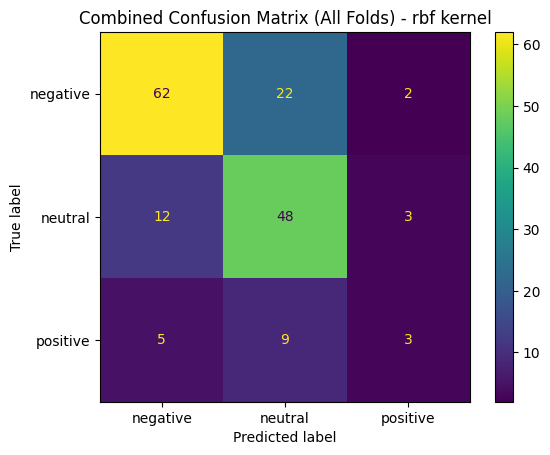


===== SVM with sigmoid kernel =====
===== K-Fold Cross Validation Results =====

Fold 1:
Training time: 0:00:00.004058
Accuracy: 0.7647

Fold 2:
Training time: 0:00:00.002077
Accuracy: 0.7059

Fold 3:
Training time: 0:00:00.002016
Accuracy: 0.8235

Fold 4:
Training time: 0:00:00.007181
Accuracy: 0.7059

Fold 5:
Training time: 0:00:00.006064
Accuracy: 0.6471

Fold 6:
Training time: 0:00:00.003063
Accuracy: 0.5294

Fold 7:
Training time: 0:00:00.003576
Accuracy: 0.8750

Fold 8:
Training time: 0:00:00.003794
Accuracy: 0.6250

Fold 9:
Training time: 0:00:00.003255
Accuracy: 0.6250

Fold 10:
Training time: 0:00:00.002948
Accuracy: 0.6250

===== Overall Model Performance =====
Mean Accuracy: 0.6926
Standard Deviation: 0.0992
Average Training Time: 0:00:00.003803

===== Combined Performance Metrics =====
Overall Accuracy: 0.6928
Overall Precision: 0.7735
Overall Recall: 0.6928
Overall F1 Score: 0.7011
Overall Error Rate: 0.3072

Combined Confusion Matrix:
[[51 27  8]
 [ 1 54  8]
 [ 1  6 10]]

<Figure size 800x600 with 0 Axes>

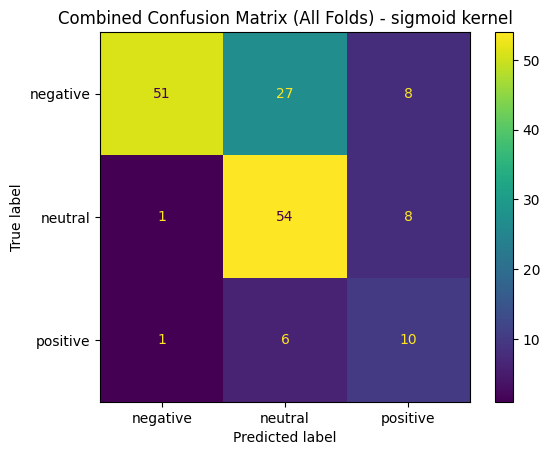

In [91]:
def svm_analysis(X_np, y_np):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    results = {}

    for kernel in kernels:
        print(f"\n===== SVM with {kernel} kernel =====")
        print("===== K-Fold Cross Validation Results =====")
        kfold = KFold(n_splits=10, shuffle=True)
        classes = np.unique(y_np)
        
        # Inisialisasi daftar untuk menyimpan hasil dari semua lipatan
        all_predictions = []
        all_true_values = []
        fold_accuracies = []
        training_times = []
        
        for i, (train_idx, test_idx) in enumerate(kfold.split(X_np)):
            X_train_fold, X_test_fold = X_np[train_idx], X_np[test_idx]
            y_train_fold, y_test_fold = y_np[train_idx], y_np[test_idx]
            
            # Latih model
            model = SVC(kernel=kernel, class_weight='balanced')
            start_time = time.time()
            model.fit(X_train_fold, y_train_fold)
            end_time = time.time()
            training_time = end_time - start_time
            training_times.append(training_time)
            
            # Buat prediksi
            y_pred = model.predict(X_test_fold)
            acc = accuracy_score(y_test_fold, y_pred)
            fold_accuracies.append(acc)
            
            # Simpan prediksi dan nilai sebenarnya untuk analisis gabungan
            all_predictions.extend(y_pred)
            all_true_values.extend(y_test_fold)
            
            print(f"\nFold {i+1}:")
            print(f"Training time: {str(datetime.timedelta(seconds=training_time))}")
            print(f"Accuracy: {acc:.4f}")
        
        # Hitung statistik
        mean_accuracy = np.mean(fold_accuracies)
        std_accuracy = np.std(fold_accuracies)
        mean_training_time = np.mean(training_times)
        
        print("\n===== Overall Model Performance =====")
        print(f"Mean Accuracy: {mean_accuracy:.4f}")
        print(f"Standard Deviation: {std_accuracy:.4f}")
        print(f"Average Training Time: {str(datetime.timedelta(seconds=mean_training_time))}")
        
        # Hitung metrik gabungan
        cm_combined = confusion_matrix(all_true_values, all_predictions, labels=classes)
        
        # Hitung performa metrik keseluruhan
        accuracy = accuracy_score(all_true_values, all_predictions)
        precision = precision_score(all_true_values, all_predictions, average='weighted', zero_division=0)
        recall = recall_score(all_true_values, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_true_values, all_predictions, average='weighted', zero_division=0)
        
        print("\n===== Combined Performance Metrics =====")
        print(f"Overall Accuracy: {accuracy:.4f}")
        print(f"Overall Precision: {precision:.4f}")
        print(f"Overall Recall: {recall:.4f}")
        print(f"Overall F1 Score: {f1:.4f}")
        print(f"Overall Error Rate: {1 - accuracy:.4f}")
        
        print("\nCombined Confusion Matrix:")
        print(cm_combined)
        print("\nCombined Classification Report:")
        print(classification_report(all_true_values, all_predictions, zero_division=0))

        # Plot confusion matrix gabungan
        plt.figure(figsize=(8,6))
        ConfusionMatrixDisplay(confusion_matrix=cm_combined, display_labels=classes).plot()
        plt.title(f"Combined Confusion Matrix (All Folds) - {kernel} kernel")
        plt.show()
        
        # Simpan hasil untuk setiap kernel
        results[kernel] = {
            'fold_accuracies': fold_accuracies,
            'mean_accuracy': mean_accuracy,
            'std_accuracy': std_accuracy,
            'mean_training_time': mean_training_time,
            'confusion_matrix': cm_combined,
            'classification_report': classification_report(all_true_values, all_predictions, zero_division=0, output_dict=True)
        }
    
    return results

# Konversi matriks sparse ke format dense
X_np = X_tfidf.toarray()
y_np = df['ground_truth_sentiment_label'].values

# Jalankan analisis
results = svm_analysis(X_np, y_np)

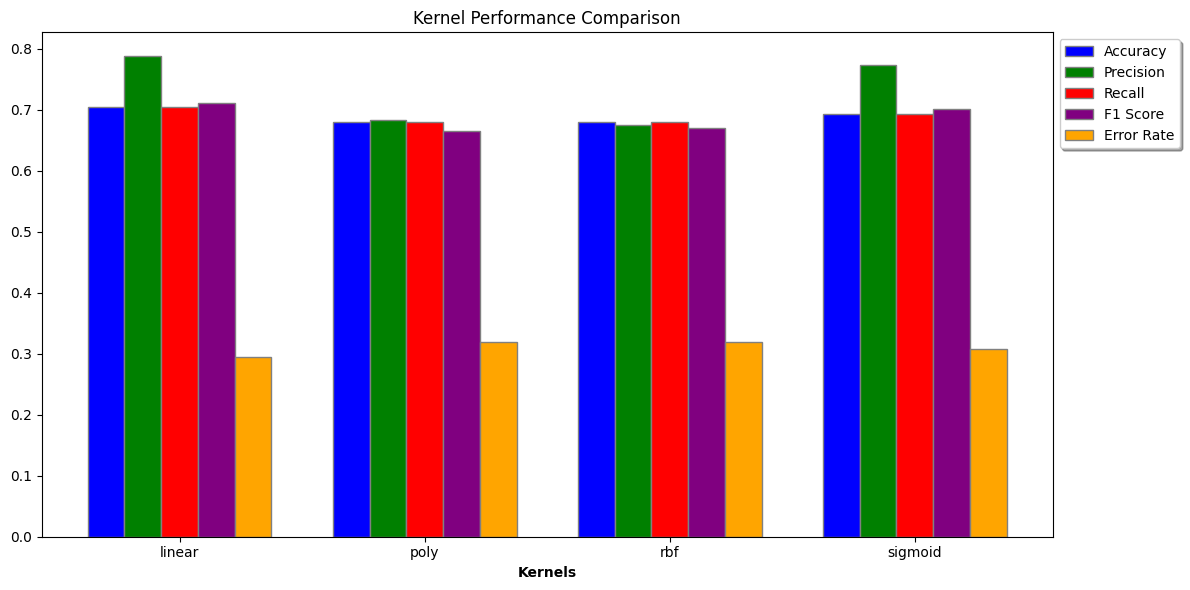

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Extract kernels and performance metrics from results
kernels = list(results.keys())
accuracy = [results[kernel]['classification_report']['accuracy'] for kernel in kernels]
precision = [results[kernel]['classification_report']['weighted avg']['precision'] for kernel in kernels]
recall = [results[kernel]['classification_report']['weighted avg']['recall'] for kernel in kernels]
f1_scores = [results[kernel]['classification_report']['weighted avg']['f1-score'] for kernel in kernels]
error_rate = [1 - acc for acc in accuracy]

# Set the width of the bars
bar_width = 0.15

# Set the positions of the bars on the x-axis
r1 = np.arange(len(kernels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

# Create the bar chart
plt.figure(figsize=(12, 6))

plt.bar(r1, accuracy, color='blue', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, precision, color='green', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r3, recall, color='red', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r4, f1_scores, color='purple', width=bar_width, edgecolor='grey', label='F1 Score')
plt.bar(r5, error_rate, color='orange', width=bar_width, edgecolor='grey', label='Error Rate')

# Add labels to the x-axis
plt.xlabel('Kernels', fontweight='bold')
plt.xticks([r + bar_width*2 for r in range(len(kernels))], kernels)

# Add a title to the chart
plt.title('Kernel Performance Comparison')

# Add a legend inside a box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, shadow=True)

# Show the chart
plt.tight_layout()
plt.show()


===== linear kernel =====
Standard Deviation: 0.0840


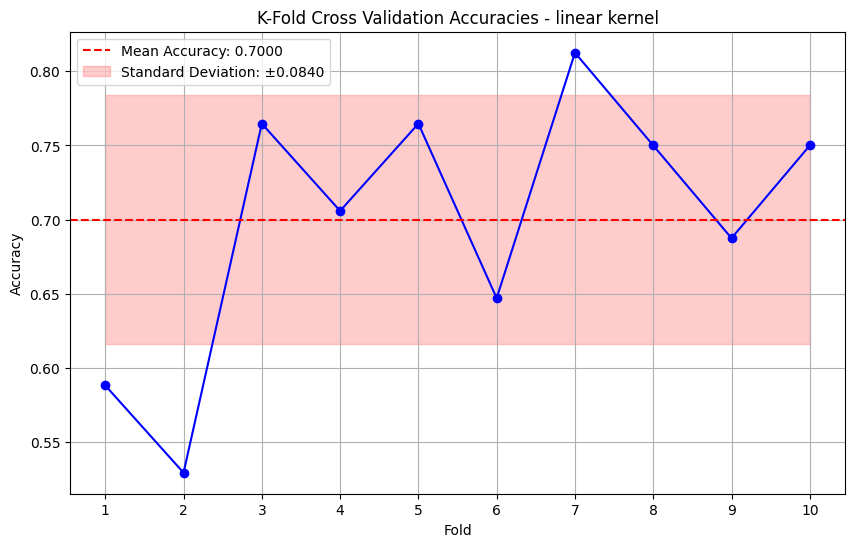


===== poly kernel =====
Standard Deviation: 0.0774


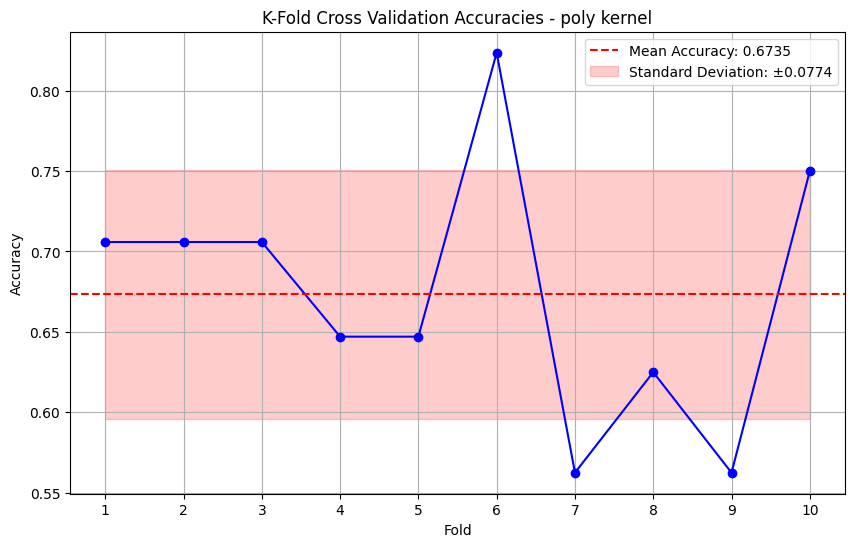


===== rbf kernel =====
Standard Deviation: 0.1022


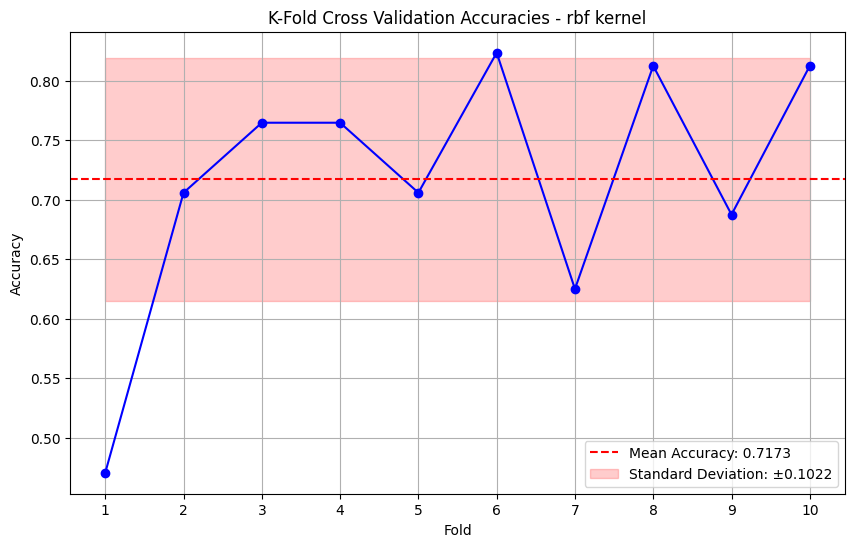


===== sigmoid kernel =====
Standard Deviation: 0.1143


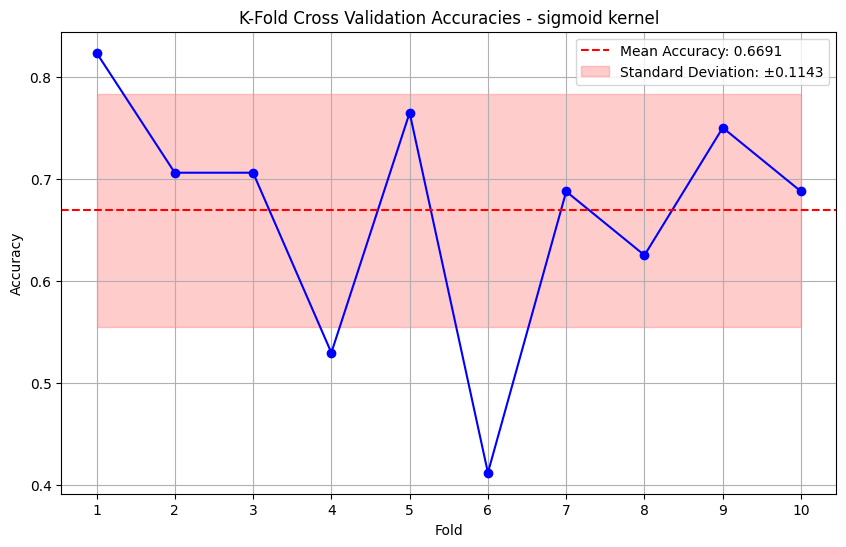

In [73]:
def plot_accuracies(results):
    for kernel, result in results.items():
        fold_accuracies = result['fold_accuracies']
        mean_accuracy = result['mean_accuracy']
        std_accuracy = result['std_accuracy']
        
        # Visualisasikan 10 akurasi
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, 11), fold_accuracies, marker='o', linestyle='-', color='b')
        plt.title(f'K-Fold Cross Validation Accuracies - {kernel} kernel')
        plt.xlabel('Fold')
        plt.ylabel('Accuracy')
        plt.xticks(range(1, 11))
        plt.grid(True)

        # Tampilkan standar deviasi
        print(f"\n===== {kernel} kernel =====")
        print(f"Standard Deviation: {std_accuracy:.4f}")

        # Tambahkan rata-rata akurasi ke plot
        plt.axhline(y=mean_accuracy, color='r', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.4f}')

        # Tambahkan standar deviasi ke plot
        plt.fill_between(range(1, 11), mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, color='r', alpha=0.2, label=f'Standard Deviation: ±{std_accuracy:.4f}')

        # Tambahkan legenda ke plot
        plt.legend()

        # Tampilkan plot
        plt.show()

plot_accuracies(results)


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 166 entries, 0 to 200
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   english_translation           166 non-null    object 
 1   textblob_polarity             166 non-null    float64
 2   textblob_sentiment_label      166 non-null    object 
 3   vader_scores                  166 non-null    object 
 4   vader_compound                166 non-null    float64
 5   vader_sentiment_label         166 non-null    object 
 6   afinn_sentiment_score         166 non-null    float64
 7   afinn_sentiment_label         166 non-null    object 
 8   ground_truth_sentiment_label  166 non-null    object 
 9   cleaned_text                  166 non-null    object 
 10  case_folded_text              166 non-null    object 
 11  tokenized_text                166 non-null    object 
 12  text_without_stopwords        166 non-null    object 
 13  stemmed_te

In [75]:
# Simpan DataFrame ke file Excel
df.to_excel('hasil analisis/hasil_sentiment_analysis_catania.xlsx', index=False)

# Konfirmasi bahwa file telah disimpan
print("DataFrame berhasil di simpan ke 'hasil_sentiment_analysis_catania.xlsx'")

DataFrame berhasil di simpan ke 'hasil_sentiment_analysis_catania.xlsx'
